# Notebook 2: CNF com Trace Exato

Este notebook implementa CNF completo com cálculo de log-likelihood via change of variables.

## Objetivos:
1. Implementar divergence_exact e CNF
2. Treinar em dados 2D e MNIST reduzido
3. Comparar com Real NVP baseline
4. Analisar escalabilidade


In [1]:
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
import time
import torch
import torch.optim as optim
from src.models.cnf import CNF
from src.models.vector_field import VectorField
from src.utils.datasets import Synthetic2D, MNISTReduced, get_dataloader
from src.utils.training import train_cnf
from src.utils.visualization import plot_data_distribution

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cpu


## 1. CNF em Dados 2D


Log-likelihood médio: 149.2738


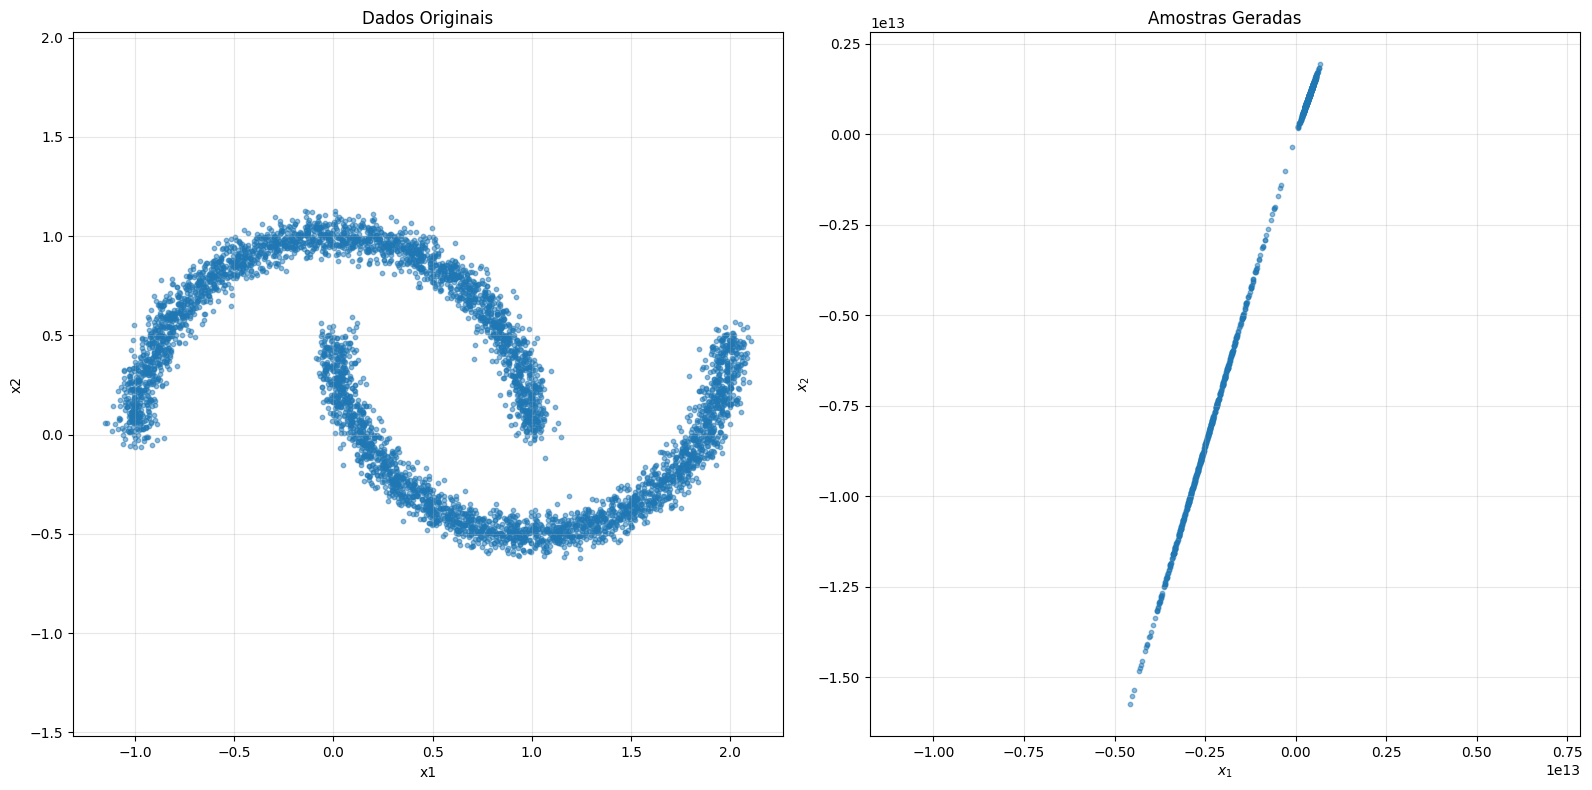

In [ ]:
# Criar dataset 2D
dataset_2d = Synthetic2D(n_samples=5000, noise=0.05, dataset_type='moons')
dataloader_2d = get_dataloader(dataset_2d, batch_size=128, shuffle=True)

# Criar e treinar CNF
vf_2d = VectorField(features=2, hidden_dims=[64, 64], time_embed_dim=16)
cnf_2d = CNF(vf_2d).to(device)
optimizer_2d = optim.Adam(cnf_2d.parameters(), lr=1e-3)

print("Treinando CNF em dados 2D...")
train_cnf(cnf_2d, dataloader_2d, optimizer_2d, device, num_epochs=10)

# Avaliar log-likelihood
cnf_2d.eval()
with torch.no_grad():
    test_data = dataset_2d.data[:1000].to(device)
    log_probs = cnf_2d.log_prob(test_data)
    print(f"Log-likelihood médio: {log_probs.mean().item():.4f}")

# Gerar amostras
samples = cnf_2d.sample(1000)
samples_np = samples.cpu().detach().numpy()

# Visualizar
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
plot_data_distribution(dataset_2d.data, ax=axes[0], title="Dados Originais")
axes[1].scatter(samples_np[:, 0], samples_np[:, 1], alpha=0.5, s=10)
axes[1].set_title("Amostras Geradas")
axes[1].set_xlabel(r'$x_1$')
axes[1].set_ylabel(r'$x_2$')
axes[1].grid(True, alpha=0.3)
axes[1].axis('equal')
plt.tight_layout()
plt.show()


## 2. CNF em MNIST Reduzido


In [6]:
# Criar dataset MNIST reduzido (100 dimensões)
print("Carregando MNIST reduzido...")
dataset_mnist = MNISTReduced(train=True, n_components=100)
dataloader_mnist = get_dataloader(dataset_mnist, batch_size=128, shuffle=True)

# Criar e treinar CNF
vf_mnist = VectorField(features=100, hidden_dims=[128, 128], time_embed_dim=32)
cnf_mnist = CNF(vf_mnist).to(device)
optimizer_mnist = optim.Adam(cnf_mnist.parameters(), lr=1e-3)

print("Treinando CNF em MNIST reduzido...")
start_time = time.time()
train_cnf(cnf_mnist, dataloader_mnist, optimizer_mnist, device, num_epochs=10)
train_time = time.time() - start_time
print(f"Tempo de treinamento: {train_time:.2f} segundos")

# Avaliar log-likelihood
cnf_mnist.eval()
with torch.no_grad():
    test_data = dataset_mnist.data[:1000].to(device)
    log_probs = cnf_mnist.log_prob(test_data)
    print(f"Log-likelihood médio: {log_probs.mean().item():.4f}")

# Tempo de sampling
start_time = time.time()
samples = cnf_mnist.sample(1000)
sample_time = time.time() - start_time
print(f"Tempo de sampling (1000 amostras): {sample_time:.2f} segundos")


Carregando MNIST reduzido...


100%|██████████| 9.91M/9.91M [00:03<00:00, 2.87MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 205kB/s]
100%|██████████| 1.65M/1.65M [00:02<00:00, 596kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.67MB/s]


Treinando CNF em MNIST reduzido...


Epoch 1/10:   0%|          | 0/469 [00:00<?, ?it/s]/home/lucas-barbosa/.virtualenvs/flow/lib/python3.12/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 1/10:   2%|▏         | 10/469 [00:56<43:04,  5.63s/it]


KeyboardInterrupt: 

## 3. Análise de Escalabilidade

**Por que trace exato não escala para MNIST completo (784 dim)?**

- Custo computacional: O(d²) onde d é a dimensão
- Para d=784: precisamos de 784 backward passes
- Cada backward é O(784) → Total O(784²) = O(614,656)
- Isso é muito lento para treinamento prático!

**Solução:** Usar Hutchinson trace estimator (FFJORD) - O(d)
